<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Loan Classifier</font></h1>
<h1 align="center"><font size="4">Capstone Project for the Machine Learning with Python Course - IBM on Coursera</font></h1>


The purpose of this project is to build a classifier, which would predict whether a loan would be paid off or would go to collection.
In order to find the best classifier for the task, we will try out all the classifiers covered in the course - kNN, Decision Tree, SVM, and Logistic Regression and compare their performance, using standard metrics.
This notebook contains all the code used for this project - from importing libraries to running performance metrics, together with brief description of each step, wherever necessary.






## Import Libraries

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline


## About Dataset

This dataset used in this project contains information about past loans. The __Loan_train.csv__ dataset, which is downloaded below, includes details of 346 customers whose loans have already been paid off or defaulted. It includes the following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Download Dataset
We will first download only the **train set** for the project, using the url given below. The final **test set** will be downloaded later on, when all the classifiers have been built.

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-06 00:26:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-08-06 00:26:07 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

It is necessary to inspect the first two columns - **Unnamed:0 and Unnamed: 0.1**. It appears that the information contained in these is some sort of an ID, and it also appears that the information in the two columns is the same.

In [5]:
# Inspect Unnamed:0
df.iloc[:,0]

0        0
1        2
2        3
3        4
4        6
5        7
6        8
7        9
8       10
9       11
10      12
11      13
12      14
13      15
14      16
15      17
16      18
17      19
18      20
19      22
20      23
21      25
22      26
23      27
24      28
25      29
26      30
27      31
28      32
29      33
      ... 
316    367
317    368
318    371
319    372
320    373
321    374
322    375
323    376
324    377
325    378
326    379
327    380
328    381
329    382
330    383
331    384
332    385
333    386
334    387
335    388
336    389
337    390
338    391
339    392
340    393
341    394
342    395
343    397
344    398
345    399
Name: Unnamed: 0, Length: 346, dtype: int64

In [6]:
# Inspect Unnamed:0.1
df.iloc[:,1]

0        0
1        2
2        3
3        4
4        6
5        7
6        8
7        9
8       10
9       11
10      12
11      13
12      14
13      15
14      16
15      17
16      18
17      19
18      20
19      22
20      23
21      25
22      26
23      27
24      28
25      29
26      30
27      31
28      32
29      33
      ... 
316    367
317    368
318    371
319    372
320    373
321    374
322    375
323    376
324    377
325    378
326    379
327    380
328    381
329    382
330    383
331    384
332    385
333    386
334    387
335    388
336    389
337    390
338    391
339    392
340    393
341    394
342    395
343    397
344    398
345    399
Name: Unnamed: 0.1, Length: 346, dtype: int64

It appears that the information in the two columns is some kind of an ID (all values are ints, they are grouped in what appears to be blocks of consecutive numbers -  some numbers are skipped.)

In [7]:
for i in range(len(df.iloc[:,0])):
    if df.iloc[i,0] != df.iloc[i,1]:
        print('Not the same')
        break
        
       

The values in **Unnamed:0 and Unnamed: 0.1** are the same. Since these two columns are also not described in the original dataset description, we decide to drop them.

## Data Pre-Processing and Visualization


### Drop Unnecessary Columns
Our first task is to drop the two unnecessary columns, mentioned above, as they don't provide any useful information, which would contribute to improving the classifier's performance.

In [8]:
# find out the exact names of the columns to be dropped
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

In [9]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)


Once this is done we ensure whether the obtained dataframe is what we expected.

In [10]:
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


And check its shape, just in case.

In [11]:
df.shape

(346, 8)

### Convert to date time object 

In [12]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


Let’s see how many of each class is in our data set 

In [13]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection. 


### Visualization and Exploratory Data Analysis

Now we are going to generate several plots, in order to gain some insights about the data.

In [14]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    seaborn-0.10.1             |             py_0         160 KB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    ca-certificates-2020.6.24  |                0         133 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.2 MB

The following packages will be UPDATED:

    ca-certificates: 2020.6.24-0        --> 2020.6.24-0       anaconda
    certifi:         2020.6.20-py36_0   --> 2020.6.20-py36_0  anaconda
    openssl:         1.1.1g-h7b6447c_0  --> 1.1.1g-h7b6447c_0 anaconda
    seaborn:         0.9.0-pyh91

An interesting question to ask is, for example, whether there is any difference in loans - amount taken, frequency, proportion of paid-off loans, by gender. Hence, we generate a plot to explore this.

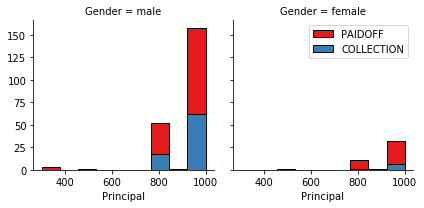

In [15]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

One can see that the dataset mostly contains data for loans taken by males. It seems like most often the loans taken are for 800 or 1000 dollars. In addition, based on the available data, the proportion of women whose loans go into collection is smaller than men's loans that go into collection, both for 800- and 1000-dollar loans.

In fact, if we group our data points by gender and loan status, we get some interesting results.

In [16]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

According to this data, 86 % of females pay their loans, while for males only 73 % do.


We now generate a plot, in which we explore loan-taking by age and gender.

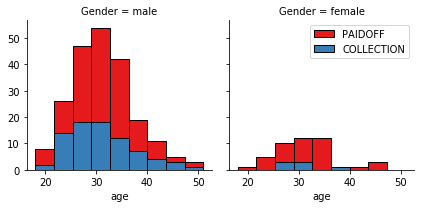

In [17]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

As one can see, the majority of loan-takers are roughly between the age of 25 and 35.

Now we move on to feature extraction and selection.

##  Feature selection/extraction

One interesting question worth exploring, is whether the day of the week when a loan is taken, is in some way related to whether a loan is paid off or not. This is explored in the plot below.

### Add a binary feature based on day of the week

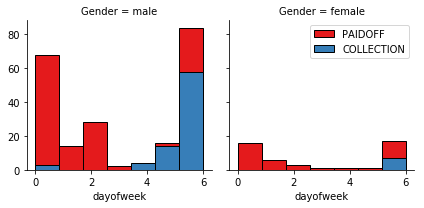

In [18]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


It seems like the proportion of loans that have gone into collection, for both men and women, is higher for loans taken from Day 4 onwards. i.e. the weekend. Hence, we are going to do feature binarization to set a threshold for loans taken before and after Day 4 (weekdays and weekend). 

In [19]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Convert categorical features to numerical values

Now, some of the variables in our dataset are categorical. However, since some of the classifiers we are going to try out can only work with numerical variables, we are going to turn the categorical variables into numerical.

Here we convert the **Gender** variable, which has two categories - 'male' and 'female', to a binary variable, taking values 0 and 1, respectively.


In [20]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### One Hot Encoding  



The other variable we need to transform is **Education**. We are going to use *One Hot Encoding*, to turn the categories of this variable into a table of 1's and 0's. Again, this is necessary, as some of the classifiers can only work with numerical values.

In [21]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [22]:
df[['Principal','terms','age','Gender','weekend','education']].head()

,Principal,terms,age,Gender,weekend,education
0,1000,30,45,0,0,High School or Below
1,1000,30,33,1,0,Bechalor
2,1000,15,27,0,0,college
3,1000,30,28,1,1,college
4,1000,30,29,0,1,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [23]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


## Feature selection

We decided to use the following features - Principal, Terms, Age, Gender, Weekend, Education( split into dummy variables - Bachelor, High School or Below, College. Now, since the loan has one pay-off date, and we have the Terms (deadline for paying off), we decided to drop the Due Date. We also dropped the Effective date (when the loan was taken), as we have the variable weekend (whether the loan was taken in the weekend or not), which we assumed carries similar information to Effective date. This, we are left with **8 features** (including the education dummy variables).

In [24]:
X = Feature.values # turn into a numpy array, as some of the algorithms require it
# Turn into float the features which will later on be rescaled
X[:,0] = X[:,0].astype(float) 
X[:,1] = X[:,1].astype(float)
X[:,2] = X[:,2].astype(float)
type(X[1,0])

numpy.int64

As to the labels, we are of course interested in predicting whether a loan is going to be paid off, our **dependent variable** is of course the **loan_status**. However, since some of the classifiers we are going to train require binary labels (e.g logistic regression classifier), we are going to first **binarize** the loan_status.

In [25]:
df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

We will of course use **load_status** as dependent variable, and all other features as independent variables.

### Split Data



We decided **not to split** the model into a train and validation set, as we are going to use **GridSearch** for identifying the optimal set of parameters for our classifiers, which also conducts cross-validation (CV), making splitting the train set obsolete.

### Scaling Data

It is easier for some of the classifiers to process features which are on the same scale. Hence, we decided to rescale our features, using **MinMaxScaler**, which rescales all values of the features to a given range - in our case **(0,1)**. However, from the available features, only **Principal, Terms**, and **Age** need rescaling, as the rest are either Binary or Dummy variables. However, since we are using cross-validation, as part of the **GridSearch**, the rescaling is done within the GridSearch.


# Classification 

Now that we have done some exploratory data analysis and have inspected the available features, it is time to proceed to building the classification models, respectively:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression


### GridSearch
When training the aforementioned models, we are going to use the GridSearch function. Before proceeding further, let us first explain what GridSearch is used for.
A Machine Learning model is defined as a mathematical model with a number of parameters that need to be learned from the data. However, there are some parameters, known as **hyperparameters** and those cannot be directly learned. They are commonly chosen by human based on some intuition or hit and trial before the actual training begins. If chosen correctly, the hyperparameters can significantly improve the model performance. Models can have many hyperparameters and finding the best combination of parameters can be treated as a search problem. [1] One way to approach this problem is through GridSearch, which allows us to try out various combinations of hyperparameters, in order to find an optimal combination.

In addition, in order to select the 'best' combination of hyperparameters, we need to choose a **scoring function**. In this case we choose the **F1 score**, which is calculated by taking the unweighted average for both precision and recall for the two labels - 0 and 1 (or, as given in the code below **f1_macro**).


Now that we have clarified the purpose of GridSearch, we proceed to training our classifiers.

# K Nearest Neighbor(KNN)

In [26]:
# import KNN classifier from sklearn
from sklearn.neighbors import KNeighborsClassifier

# import GridSearch and pipeline libraries, as well as libs needed for preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer


Now, in order to find the optimal hyperparameters for the kNN classifiers, we are going to use GridSearch. But what we need to do first is decide on which hyperparameters to iterate over. In this case, we decided to only consider the number of neighbours (k), as well as the weights assigned to the neighbours, keeping all other hyperparameters with their default values.



In [27]:
# Number of neighbours
Ks = [1,2,3,4,5,6,7,8,9,10]

# Weights

# ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.

#‘distance’ : weight points by the inverse of their distance. in this case, 
#             closer neighbors of a query point will have a greater influence than neighbors which are further away.

weights = ['uniform', 'distance']


In [28]:
# Declaring a ColumnTransformer to only apply MinMaxScaler() only to columns 0,1,2
transformer = ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0,1,2])], remainder='passthrough')
estimators = [("t", transformer), ("clf", KNeighborsClassifier())]

# Declaring a pipeline, which excecutes the steps listed above
pipe = Pipeline(estimators)

# Declare a parameter grid
param_grid = {'clf__n_neighbors': Ks, 'clf__weights':weights}

# Executing Gridsearch with number of folds cv = 5 for the cross-validation
kNN = GridSearchCV(pipe, param_grid, scoring = 'f1_macro',  cv=5)

# Note that GridSearch is conducted on the WHOLE train set, as CV is used (so at each iteration one of the folds is held out as a validation set)
kNN.fit(X, y)

# Finding the best hyperparameters combination, established after iteration
kNN.best_params_


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

{'clf__n_neighbors': 4, 'clf__weights': 'uniform'}

Thus, we establish that the optimal number of neighbours in this case is **k = 4** and the weight function is **weight = uniform**.

In [29]:
# Load model with hyperparameters
kNN.best_estimator_

Pipeline(memory=None,
     steps=[('t', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1)), [0, 1, 2])])), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform'))])

Now that we have trained the kNN and identified optimal hyperparameters for the given problem and provided training data, we proceed with training a Decision Tree classifier.

# Decision Tree

In [30]:
# import the Decision Tree library
from sklearn.tree import DecisionTreeClassifier

# import GridSearch and pipeline libraries, as well as libs needed for preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer



Now, in order to find the optimal hyperparameters for the Decision Tree, we are going to use GridSearch. In this case, we decided to consider criterion and max_depth, keeping all other hyperparameters with their default values.


In [31]:
# Criterion

# ‘gini’ : Gini impurity

#‘entropy’ : for the information gain

criterion = ['gini', 'entropy']

# Max_depth
# Maximum depth of the three

max_depth = [4, 6, 8, 10,12]

In [32]:
# Declaring a ColumnTransformer to only apply MinMaxScaler() only to columns 0,1,2
transformer = ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0,1,2])], remainder='passthrough')
estimators = [("t", transformer), ("clf", DecisionTreeClassifier())]

# Declaring a pipeline, which excecutes the steps listed above
pipe = Pipeline(estimators)

# Declare a parameter grid
param_grid = {'clf__criterion': criterion, 'clf__max_depth': max_depth}

# Executing Gridsearch with number of folds cv = 5 for the cross-validation
dtree = GridSearchCV(pipe, param_grid, scoring = 'f1_macro', cv=5)

# Note that GridSearch is conducted on the WHOLE train set, as CV is used (so at each iteration one of the folds is held out as a validation set)
dtree.fit(X, y)

# Finding the best hyperparameters combination, established after iteration
dtree.best_params_

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

{'clf__criterion': 'entropy', 'clf__max_depth': 10}

Thus, we establish that the optimal max_depth in this case is **max_depth = 10** and the criterion function is **criterion = entropy**.

In [33]:
# Load model with hyperparameters
dtree.best_estimator_

Pipeline(memory=None,
     steps=[('t', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1)), [0, 1, 2])])), ('clf', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_dep...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

# Support Vector Machine

In our case we are going to focus on three hyperparameters - kernel, gamma, and C.
In our case we consider the standard four kernels, provided for SVM in sklearn.
Furthermore, the parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.
In addition, when training an SVM with the Radial Basis Function (RBF) kernel, the parameter gamma must be considered. It defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected. [2]

In [34]:
# import SVM library
from sklearn.svm import SVC

# import GridSearch and pipeline libraries, as well as libs needed for preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer


In [35]:
# kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Regularization values
Cs = [0.001, 0.01, 0.1, 1, 10]

# Gammas for the RBF kernel
gammas = [0.001, 0.01, 0.1, 1]



In [36]:
# Declaring a ColumnTransformer to only apply MinMaxScaler() only to columns 0,1,2
transformer = ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0,1,2])], remainder='passthrough')
estimators = [("t", transformer), ("clf", SVC())]

# Declaring a pipeline, which excecutes the steps listed above
pipe = Pipeline(estimators)

# Declare a parameter grid
param_grid = {'clf__C': Cs, 'clf__gamma':gammas,'clf__kernel':kernels}

# Executing Gridsearch with number of folds cv = 5 for the cross-validation
svm = GridSearchCV(pipe, param_grid, scoring = 'f1_macro', cv=5)

# Note that GridSearch is conducted on the WHOLE train set, as CV is used (so at each iteration one of the folds is held out as a validation set)
svm.fit(X, y)

# Finding the best hyperparameters combination, established after iteration
svm.best_params_


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/met

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/met

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/met

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/uti

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/met

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetric

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/sit

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/uti

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: 

{'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': 'sigmoid'}

According to the GridSearch output, best parameters are **kernel = 'sigmoid'**, and **C = 1**. 
Since gamma is a hyperparameter, related to the RBF kernel, it is omitted.

In [37]:
# Load best model with hyperparameters
svm.best_estimator_

Pipeline(memory=None,
     steps=[('t', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1)), [0, 1, 2])])), ('clf', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Now we proceed to fitting the last classifier required, namely Logistic Regression.

# Logistic Regression

In [38]:
# import logistic regression library
from sklearn.linear_model import LogisticRegression

# import GridSearch and pipeline libraries, as well as libs needed for preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [39]:
# Choose penalty
penalty = ['l1', 'l2']

# Choose regularization parameter
Cs = [0.001, 0.01, 0.1, 1, 10]

In [40]:
# Declaring a ColumnTransformer to only apply MinMaxScaler() only to columns 0,1,2
transformer = ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0,1,2])], remainder='passthrough')
estimators = [("t", transformer), ("clf", LogisticRegression())]

# Declaring a pipeline, which excecutes the steps listed above
pipe = Pipeline(estimators)

# Declare a parameter grid
param_grid = {'clf__penalty' : penalty,'clf__C' : Cs,'clf__solver' : ['liblinear']}

# Executing Gridsearch with number of folds cv = 5 for the cross-validation
logreg = GridSearchCV(pipe, param_grid, scoring = 'f1_macro', cv=5)

# Note that GridSearch is conducted on the WHOLE train set, as CV is used (so at each iteration one of the folds is held out as a validation set)
logreg.fit(X, y)

# Finding the best hyperparameters combination, established after iteration
logreg.best_params_



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/met

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/uti

{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

According to the GridSearch output, best parameters are **C = 1**, and **penalty = l2**. 
The solver parameter was chosen to be **liblinear**, no other solvers were explored.

Now that we have trained all classifiers and tuned the hyperparameters using GridSearch, we proceed to evaluating their performance on the test set.

# Model Evaluation using Test set

We are going to use Jaccard similarity score and F1 score to evaluate all classifiers, as well as logloss only for the logistic regression classifier. But before we proceed to model evaluation, first we need to load the test set.

### Load Test set

First, download and load the test set:

In [41]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-06 00:29:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-06 00:29:29 (340 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [42]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [43]:
test_df.shape

(54, 10)

### Test set preprocessing

In [44]:
# remove the first two columns, as they are not used
test_df = test_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
test_df.head()


,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [45]:
test_df.shape

(54, 8)

In [46]:
# transform due_date and effective_date to datetime format 
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [47]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [48]:
# transform Gender
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [49]:
# Transform test set as the train set was transformed
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [50]:
Feature_test.shape

(54, 8)

In [51]:
# Convert test_df to a numpy array and first three features to float
X_test = Feature_test.values # turn into a numpy array, as some of the algorithms require it
# Turn into float the features which will later on be rescaled
X_test[:,0] = X_test[:,0].astype(float) 
X_test[:,1] = X_test[:,1].astype(float)
X_test[:,2] = X_test[:,2].astype(float)
X_test[0:5,:]

array([[1000,   30,   50,    1,    0,    1,    0,    0],
       [ 300,    7,   35,    0,    1,    0,    0,    0],
       [1000,   30,   43,    1,    1,    0,    1,    0],
       [1000,   30,   26,    0,    1,    0,    0,    1],
       [ 800,   15,   29,    0,    1,    1,    0,    0]])

In [52]:
X_test.shape

(54, 8)

In [53]:
# Binarize test set labels
test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
y_test = test_df['loan_status'].values
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Evaluation Criteria

In [54]:
# import Jaccard score, f1 score, and log_loss, in order to evaluate the trained classifiers
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

Before continuining to evaluating each of the trained classifiers, it is worth briefly discussing any specificities (parameters) that we have chosen for the evaluation measures selected.

### Jaccard Similarity Score

All parameters of this evaluation measure are left with their default values.

### F1 Score

Now, there are two parameters which we are going to comment on, regarding the F1 score.
The first parameter is **pos_label**, which is basically the value of the labels that we are interested in. In our case, we are interested in whether a person would pay off their loan, so we choose **pos_label = 1** (where 1 denotes 'PAIDOFF').
The other parameter worth considering is **average**. This parameter tells us how the F1 score is calculated, or, more precisely, how are the precision and recall calculated based on the two labels. In our case we choose **average = 'macro'**, which takes the average for the two labels for both precision and recall, and then calculates the F1 score. Now, note that both our train and test set are imbalanced (there are significantly more 1 labels, than 0 labels), and there is also a possibility for accounting for that (giving more weight to the precision and recall for the 1 labels), but this may result in overly-optimistic F1 score, which may be misleading. By choosing 'macro', we give equal weight to the precision and recall for both 0 and 1 labels.

### LogLoss
All the parameters for log_loss are left with their default values.

In [55]:

# Calculate Jaccard and F1 score for kNN
yhat_knn = kNN.predict(X_test)

print('kNN Jaccard Similarity Score:', jaccard_similarity_score(yhat_knn, y_test))
print('kNN F1 Score:', f1_score(y_test, yhat_knn, pos_label=1, average = 'macro'))

kNN Jaccard Similarity Score: 0.6666666666666666
kNN F1 Score: 0.5660714285714286


In [56]:
# Calculate Jaccard and F1 score for Decision Tree
yhat_dtree = dtree.predict(X_test)

print('Decision Tree Jaccard Similarity Score:', jaccard_similarity_score(yhat_dtree, y_test))
print('Decision Tree F1 Score:', f1_score(y_test, yhat_dtree, pos_label = 1,  average = 'macro'))

Decision Tree Jaccard Similarity Score: 0.6666666666666666
Decision Tree F1 Score: 0.5846153846153845


In [57]:
# Calculate Jaccard and F1 score for SVM

yhat_svm = svm.predict(X_test)

print('SVM Jaccard Similarity Score:', jaccard_similarity_score(yhat_svm, y_test))
print('SVM F1 Score:', f1_score(y_test, yhat_svm, pos_label = 1,  average = 'macro'))

SVM Jaccard Similarity Score: 0.7037037037037037
SVM F1 Score: 0.5433403805496828


In [58]:
# Calculate Jaccard and F1 score, as well as logloss for Logistic Regression

yhat_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)

print('LogReg Jaccard Similarity Score:', jaccard_similarity_score(yhat_logreg, y_test))
print('LogReg F1 Score:', f1_score(y_test, yhat_logreg, pos_label=1,  average = 'macro'))
print('LogReg LogLoss:', log_loss(y_test, y_prob_logreg))


LogReg Jaccard Similarity Score: 0.7407407407407407
LogReg F1 Score: 0.4864130434782608
LogReg LogLoss: 0.4904962072094492


The poor F1 score and the high logloss suggest that the logistic regression likely classifies incorrectly the less common label. Hence, we inspect the occurences of 0 and 1 in both test set and set of predicted labels.

In [62]:
# check frequency of labels in the test set
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 14, 1: 40}

In [63]:
# check frequency of labels in the predicted-labels set
unique, counts = np.unique(yhat_logreg, return_counts=True)
dict(zip(unique, counts))

{0: 2, 1: 52}

As one can see, the logistic regression classifier does very poorly at predicting the 0 label.

# Report


Now we proceed to looking at comparing all algorithms.

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.6667  | 0.5661   | NA      |
| Decision Tree      | 0.6852  | 0.5993   | NA      |
| SVM                | 0.7037  | 0.5433   | NA      |
| LogisticRegression | 0.7407  | 0.4864   | 0.4905  |

## Conclusion

#### Jaccard Similarity
As one can see, Logistic Regression does slightly better than the other ones, when comparing by **Jaccard Similarity score**, but is doing poorly on the F1 Score. As established earlier, the reason for that is that it simply predicts a large number of 1s and very small number of 0s correctly.

#### F1 Score

As one can see, the Decision Tree classifier does slightly better than kNN and SVM, while Logistic Regression does significantly more poorly. This is not surprising, considering that this classifier does very poorly at predicting correctly labels with value 0.

#### LogLoss

The logloss is not very low, which is not surpring, considering that it does poorly at classifying correctly the 0 labels.


#### Reframing the question and need for different metrics
Now, one could ask whether we made the right choice by chosing **average = macro** parameter for both the cross-validation and model evaluation metric F1-score. In this case this seemed like a reasonable choice, because it gives equal importance to the ability of the model to predict 1 or 0. If one, however, wants to put more emphasis on one of the two outcomes - paid-off loan or loan to go into collection, different parameters of the F1 scores should be chosen.

## Bibliography


[1] www.geeksforgeeks.org. (2020). SVM Hyperparameter Tuning using GridSearchCV | ML. [online] Available at: https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/ [Accessed 4 Aug. 2020].

[2] Scikit-learn.org. (2020). Support Vector Machines. [online] Available at:https://scikit-learn.org/stable/modules/svm.html#implementation-details [Accessed 4 Aug. 2020].